# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

**Team Raja Terakhir:**
- Ananda Azharuddin Salima
- Gastiadirijal N.K
- Shafa Rafazanda
- Virza Aulia Rachman

# Preparation

In [1]:
# Load required library
# Import Required Library
import cv2
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


*   `import cv2` mengimpor pustaka OpenCV, yang digunakan untuk mengolah gambar dan video.
*   `numpy` dan `pandas`: Digunakan untuk manipulasi data dan operasi numerik.
*   `fetch_lfw_people`: Digunakan untuk memuat dataset Labeled Faces in the Wild (LFW) dari pustaka `scikit-learn`.
*   `train_test_split`: Untuk membagi dataset menjadi set pelatihan dan pengujian.
*   `SVC`: Algoritma Support Vector Machine dari `scikit-learn` untuk klasifikasi.
*   `confusion_matrix`, `accuracy_score`, `classification_report`: Metrik evaluasi model untuk mengukur performa.
*   `matplotlib.pyplot` dan `seaborn`: Pustaka untuk visualisasi data, seperti menampilkan matriks kebingungan atau plot histogram.

# Load Data

In [17]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True

# Load dataset with conditions
faces = fetch_lfw_people(min_faces_per_person=200, color=True, resize=0.5)  # Optional resize for memory efficiency

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')




Total Label: 2
Data dimension: (766, 62, 47, 3)
Images flatten dimension: (766, 8742)




1.   Memuat Dataset LFW

Gunakan fungsi `fetch_lfw_people` dari pustaka `scikit-learn`. Dataset ini secara otomatis akan mengunduh gambar wajah dan label yang terkait.

*   `min_faces_per_person=10`: Memastikan setiap label memiliki minimal 10 gambar (sesuai persyaratan kuis).
*   `color=True`: Memuat gambar dalam format RGB.
*   `resize`: Opsional, digunakan untuk mengubah ukuran gambar agar lebih ringan dan mudah diproses.

2.   Menampilkan informasi dataset

*   Total Label
*   Data Dimension
*   Image Flatten dimension

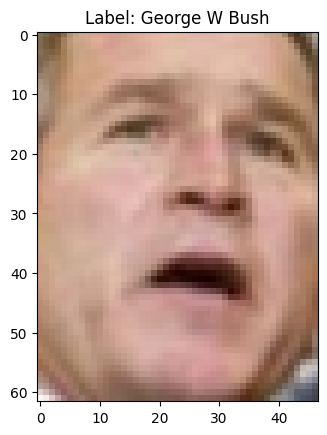

In [18]:
X = faces.images  # Stores the face image to be processed.
y = faces.target  # Stores the labels associated with each image (as Integer).

# Show some images to make sure the dataset has been loaded correctly
plt.imshow(X[0])
plt.title(f"Label: {faces.target_names[y[0]]}")
plt.show()



3.   Ekstraksi Data dan Label:

Pisahkan gambar dan label dari dataset. Gambar-gambar akan digunakan untuk ekstraksi fitur (histogram), sedangkan label akan digunakan untuk melatih model.
*   `X`: Menyimpan gambar wajah yang akan diproses.
*   `y`: Menyimpan label yang berhubungan dengan setiap gambar (target).





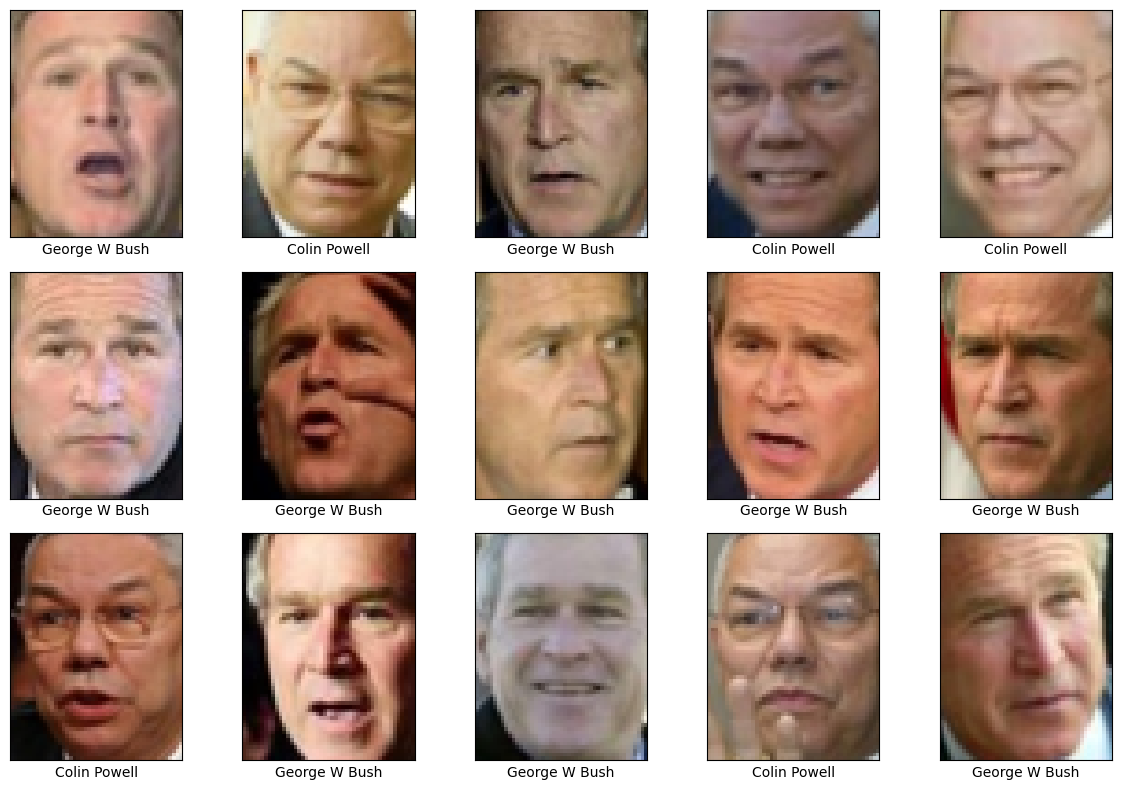

In [19]:
# Check by Plotted Images
# Generate random 15 images

rand_labels = np.random.choice(len(faces.data), 15, replace=False)

fig, ax = plt.subplots(3, 5, figsize=(12, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]])  # Default color map for RGB images
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Adjust layout after plotting
fig.tight_layout()


*   `np.random.choice`: Digunakan untuk memilih 15 indeks acak dari dataset tanpa pengulangan (replace=False).
*   `imshow()` tanpa `cmap`: Karena gambar adalah RGB, maka dari itu tidak perlu menggunakan peta warna apa pun.
*   `tight_layout()` di akhir: Dipanggil setelah semua gambar dan label ditambahkan untuk memastikan tampilan tata letak lebih rapi.


**Kesimpulan**

Langkah Load data ini akan:

1.   Memuat dataset LFW dengan minimal 10 gambar per label.
2.   Mengambil gambar dalam format RGB.
3.   Memisahkan gambar dan label untuk proses lebih lanjut.
4.   Memeriksa dan memvisualisasikan data untuk memastikan semuanya berjalan sesuai.

# Preprocessing

In [ ]:
'''
    Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,

    1. Standardisasi nilai fitur ataupun label
    2. Penyesuaian ukuran gambar
    3. Perubahan colorspace gambar
    4. dsb
'''

## Normalisasi Gambar

In [20]:
# Normalisasi gambar dari rentang [0, 255] ke [0, 1]
X_normalized = X / 255.0


*   **Alasan**: Normalisasi ini bisa membantu model bekerja lebih stabil, terutama ketika menggunakan algoritma seperti SVM yang sensitif terhadap skala data.


# Features Extraction

In [ ]:
'''
    Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
    Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

    Hints:
        Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
        Anda dapat menggunakan fungsi np.histrogram dari library numpy
'''

In [21]:
# Fungsi untuk mengekstrak histogram dari satu gambar
def extract_histogram(image, bins=(8, 8, 8)):
    # Menghitung histogram untuk setiap channel (R, G, B)
    hist_r = cv2.calcHist([image], [0], None, [bins[0]], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [bins[1]], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [bins[2]], [0, 256])

    # Normalisasi histogram agar nilai berada di rentang [0, 1]
    hist_r = cv2.normalize(hist_r, hist_r).flatten()
    hist_g = cv2.normalize(hist_g, hist_g).flatten()
    hist_b = cv2.normalize(hist_b, hist_b).flatten()

    # Menggabungkan histogram R, G, dan B menjadi satu vektor fitur
    hist = np.concatenate([hist_r, hist_g, hist_b])

    return hist

# Ekstraksi histogram untuk seluruh dataset
X_hist = np.array([extract_histogram(image) for image in faces.images])

# Memeriksa dimensi hasil ekstraksi fitur histogram
print("Dimensi fitur histogram: ", X_hist.shape)

Dimensi fitur histogram:  (766, 24)


**Penjelasan Kode:**

1.   `extract_histogram()`:


*   Menggunakan fungsi OpenCV `cv2.calcHist()` untuk menghitung histogram dari setiap channel gambar (Red, Green, dan Blue).
*   Normalisasi dilakukan menggunakan `cv2.normalize()` agar distribusi histogram dapat dibandingkan antar gambar.
*   Histogram dari tiga channel (R, G, B) kemudian digabungkan menjadi satu vektor fitur dengan `np.concatenate()`.

2.   Ekstraksi Histogram dari Dataset:
*   Looping dilakukan untuk seluruh gambar dalam dataset `faces.images` dan histogram diekstrak dari setiap gambar.
3.   Hasil Akhir:
*   Setelah diekstraksi, vektor histogram untuk setiap gambar disimpan di variabel `X_hist`. Dimensi `X_hist` akan menjadi `(n_samples, total_bins)`, di mana `total_bins` adalah jumlah total bins dari ketiga channel histogram yang digabungkan.


**Pengaturan Parameter Bins:**

*   `bins` menentukan jumlah "bucket" yang digunakan untuk membagi rentang intensitas warna. Misalnya, dengan `(8, 8, 8)` bins, kita membagi setiap channel menjadi 8 bagian, sehingga total ada 8*8*8 = 512 fitur per gambar. Anda bisa menyesuaikan jumlah bins untuk bereksperimen dengan kualitas fitur yang dihasilkan.

# Build Model

In [ ]:
'''
    Pada bagian ini lakukan proses pembuatan model,

    1. Pembuatan data training dan data testing
    2. Pembuatan objek model
    3. Proses fitting model
'''

In [25]:
# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_hist, faces.target, test_size=0.2, random_state=42)


*   Dataset dibagi menjadi dua: 80% untuk training dan 20% untuk testing.
*   X_hist adalah data fitur, dan faces.target adalah label.

In [26]:
# Step 2: Initialize SVM model (kernel linear atau RBF)
model = SVC(kernel='rbf', random_state=42)  # Anda bisa mencoba 'rbf' atau kernel lainnya juga


*   Model SVM dibuat dengan kernel RBF yang digunakan untuk klasifikasi.
*   Kernel RBF dipilih karena cocok untuk data non-linear.

In [27]:
# Step 3: Train the model with training data
model.fit(X_train, y_train)

SVC(random_state=42)


*   Model dilatih menggunakan data training untuk mempelajari pola dari data.

In [28]:
# Step 4: Make predictions on the test data
y_pred = model.predict(X_test)


*   Model digunakan untuk memprediksi data testing (data yang belum pernah dilihat oleh model).

In [29]:
# Step 5: Evaluate the model (Accuracy and Classification Report)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Mendapatkan label unik dari data yang sebenarnya
unique_labels = np.unique(y_test)

# Cetak laporan klasifikasi dengan parameter 'labels'
print("Classification Report:\n", classification_report(y_test, y_pred, labels=unique_labels, target_names=faces.target_names[unique_labels]))

Accuracy: 0.7012987012987013
Classification Report:
                precision    recall  f1-score   support

 Colin Powell       0.00      0.00      0.00        46
George W Bush       0.70      1.00      0.82       108

     accuracy                           0.70       154
    macro avg       0.35      0.50      0.41       154
 weighted avg       0.49      0.70      0.58       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



*   Menghitung akurasi: seberapa sering prediksi model sesuai dengan label yang sebenarnya.
*   Precision: Akurasi prediksi per kelas.
*   Recall: Berapa banyak data yang terprediksi benar.
*   F1-score: Gabungan precision dan recall.

# Evaluation

In [ ]:
'''
    Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
    dengan menggunakan metric akurasi dan juga classfication report

    Hints:
        Anda dapat menggunakan referensi Jobseet 4 Percobaan 5
'''

In [24]:
# Evaluasi Model pada Data Training
print("Evaluation on Training Data:")

# Prediksi hasil dari data training
y_train_pred = model.predict(X_train)

# Menghitung akurasi untuk data training
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Classification report untuk data training
print("Training Classification Report:\n", classification_report(y_train, y_train_pred, labels=unique_labels, target_names=faces.target_names[unique_labels]))

# Evaluasi Model pada Data Testing
print("\nEvaluation on Testing Data:")

# Prediksi hasil dari data testing
y_test_pred = model.predict(X_test)

# Menghitung akurasi untuk data testing
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)

# Classification report untuk data testing
print("Testing Classification Report:\n", classification_report(y_test, y_test_pred, labels=unique_labels, target_names=faces.target_names[unique_labels]))


Evaluation on Training Data:
Training Accuracy: 0.6895424836601307
Training Classification Report:
                precision    recall  f1-score   support

 Colin Powell       0.00      0.00      0.00       190
George W Bush       0.69      1.00      0.82       422

     accuracy                           0.69       612
    macro avg       0.34      0.50      0.41       612
 weighted avg       0.48      0.69      0.56       612


Evaluation on Testing Data:
Testing Accuracy: 0.7012987012987013
Testing Classification Report:
                precision    recall  f1-score   support

 Colin Powell       0.00      0.00      0.00        46
George W Bush       0.70      1.00      0.82       108

     accuracy                           0.70       154
    macro avg       0.35      0.50      0.41       154
 weighted avg       0.49      0.70      0.58       154



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

**Inti dari Evaluasi:**

*   `Akurasi`: Mengukur seberapa benar prediksi model (presentase tebakan yang benar).
*   `Classification Report`: Menampilkan performa model untuk tiap kelas, termasuk seberapa sering model menebak dengan benar dan seberapa lengkap data yang ditebak dengan benar.

Evaluasi ini dilakukan dua kali, pada data `training` (data yang digunakan untuk melatih model) dan `testing` (data baru untuk menguji model).





---

**Challenge**

Confusion Matrix untuk evaluasi tambahan

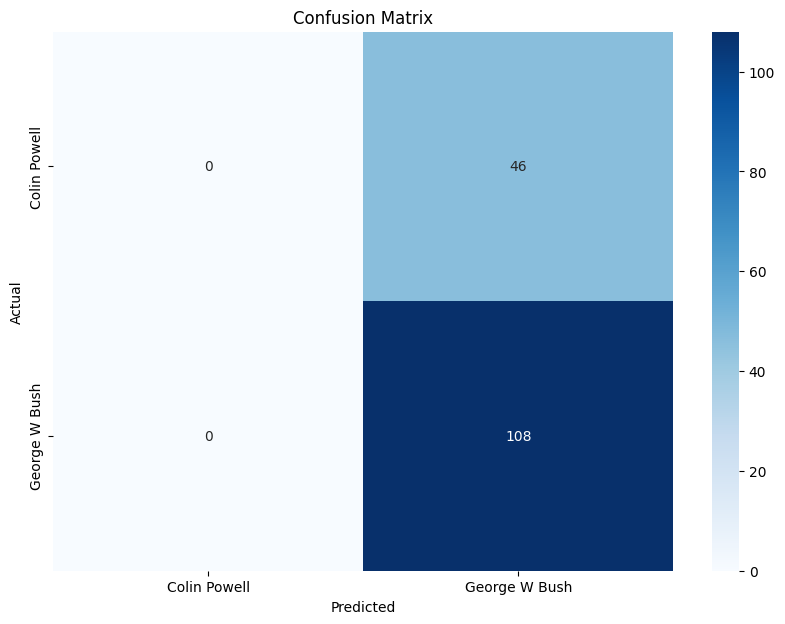

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names[unique_labels], yticklabels=faces.target_names[unique_labels])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



---



**Menggunakan fitur lain selain histogram**

# HOG (Histogram of Oriented Gradients)

In [32]:
from skimage.feature import hog

def extract_hog_features(image):
    # Ekstraksi HOG untuk setiap channel warna (R, G, B)
    hog_r = hog(image[:, :, 0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_g = hog(image[:, :, 1], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_b = hog(image[:, :, 2], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    # Menggabungkan HOG dari setiap channel menjadi satu vektor fitur
    features = np.concatenate((hog_r, hog_g, hog_b))

    return features





*  ` hog()` digunakan untuk mengekstrak fitur HOG dari gambar.
*   Gambar terdiri dari 3 channel warna (R, G, B), jadi HOG diekstrak secara terpisah untuk masing-masing channel.
*   image`[:, :, 0]` mengacu pada channel merah, `image[:, :, 1]` untuk hijau, dan `image[:, :, 2]` untuk biru.
*   Setelah HOG diekstrak untuk masing-masing channel, hasilnya digabungkan menggunakan `np.concatenate()` sehingga menjadi satu vektor fitur.



In [33]:
X_hog = np.array([extract_hog_features(image) for image in faces.images])




*   Menggunakan list comprehension untuk menerapkan fungsi `extract_hog_features` pada semua gambar dalam dataset `faces`.
*   `X_hog` adalah matriks fitur HOG yang dihasilkan dari seluruh gambar dalam dataset.




In [35]:
# Step 1: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_hog, faces.target, test_size=0.2, random_state=42)

# Step 2: Initialize SVM model
model = SVC(kernel='linear', random_state=42)

# Step 3: Train the model with training data
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)



*   `train_test_split()` digunakan untuk membagi data fitur (X_hog) dan label (faces.target) menjadi set pelatihan dan set pengujian.
*   SVM (Support Vector Machine) adalah model yang digunakan untuk melakukan klasifikasi. Di sini, kernel linear digunakan, yang umumnya cocok untuk masalah klasifikasi dengan data yang dapat dipisahkan secara linier.
*   `model.fit(X_train, y_train)` melatih model menggunakan data pelatihan.



In [36]:
# Step 4: Make predictions on the test data
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9935064935064936
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        46
           1       0.99      1.00      1.00       108

    accuracy                           0.99       154
   macro avg       1.00      0.99      0.99       154
weighted avg       0.99      0.99      0.99       154





*   `model.predict(X_test)` memprediksi label untuk data pengujian berdasarkan model yang sudah dilatih.
*   `accuracy_score(y_test, y_pred)` menghitung akurasi model, yaitu persentase prediksi yang benar.
*   `classification_report(y_test, y_pred)` memberikan laporan detail tentang performa klasifikasi, termasuk precision, recall, F1-score, dan support untuk setiap label.


**Kesimpulan:**
Kode ini melakukan klasifikasi gambar wajah dengan fitur HOG, kemudian menggunakan SVM sebagai model klasifikasi. Setelah pelatihan, model dievaluasi dengan metrik akurasi dan laporan klasifikasi untuk mengukur performanya pada data pengujian.







